<a href="https://colab.research.google.com/github/For-Chance/BigDataPanel/blob/master/myDL/v42%20%E9%94%9A%E6%A1%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 锚框
- 一类目标检测算法是基于锚框
  - 提出多个被称为锚框的区域
  - 预测每个锚框里是否含有关注的物体
  - 如果是，预测从这个锚框到真实边缘框的偏移

IoU-交并比
- IoU用来计算两个框之间的相似度
  - 0表示无重叠，1表示重合
- 这是jacquard指数的一个特殊的情况
  - 给定两个集合A和B
  - $J(A,B)=\frac{|A ⋂ B|}{|A ⋃ B|}$

赋予锚框标号
- 每个锚框是一个训练样本
- 将每个锚框，妖媚标注成背景，要么关联上一个真实边缘框
- 我们会生成大量的锚框
  - 这个导致大量的负类样本

使用非极大抑制（NMS)输出
- 每个锚框预测一个边缘框
- NMS可以合并相似的预测
  - 选中是非背景类的最大预测值
  - 去掉所有其它和它IoU值大于$\theta$的预测
  - 重复上述过程直到所有预测要么被选中，要么被去掉

总结
- 一类目标检测算法基于锚框来预测
- 首先生成大量锚框，并赋予标号，每个锚框作为一个样本进行训练
- 在预测时，使用NMS来去掉冗余的预测

## 代码

In [16]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简输出精度

锚框的宽度和高度分别是$ws\sqrt{r}$和$hs/\sqrt{r}$.我们只考虑组合
$$
(s_1,r_1),(s_1,r_2),…,(s_1,r_m),(s_2,r_1),(s3,r_1),\dots,(s_n,r_1)
$$
其中，s表示锚框占图片的百分比，r表示高宽比

In [17]:
# 给定size和ratios，依次生成锚框
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [19]:
img = d2l.plt.imread('sample_data/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 2042040, 4])

可以看到生成了2042040个锚框

访问以（250，250）为中心的第一个锚框，每个像素有五个锚框

In [20]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [21]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

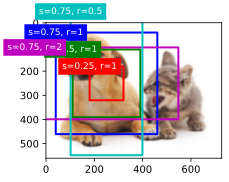

In [22]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

IoU

In [23]:
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [24]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [25]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [27]:
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，我们标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    # 返回偏移
    return (bbox_offset, bbox_mask, class_labels)

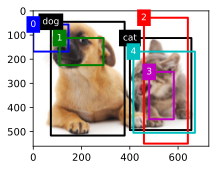

In [28]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [29]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

In [30]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [31]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

offset

In [32]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

In [33]:
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [34]:
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [35]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [36]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

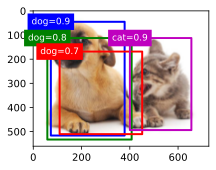

In [37]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [38]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

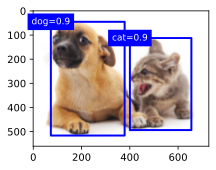

In [39]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)